In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import os

# Keras Imports
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, add, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils.vis_utils import plot_model
import re
from sklearn.preprocessing import MinMaxScaler

import os
from pathlib import Path
import os.path as osp

C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\softwares\conda4.8.2-python3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\softwares\conda4.

In [2]:
data_path = osp.join(os.getcwd(),'Data')
model_path = osp.join(os.getcwd(),'Models')
model_data = pd.read_csv(data_path  + "/model.csv")

In [3]:
model_data = model_data.drop(['Unnamed: 0'],axis=1)

In [4]:
model_data.isnull().sum() #No missing data

Date                     0
News                     0
cap                      0
stochaistic_k_percent    0
stochaistic_D            0
Momentum                 0
rate_of_change           0
William_R_percent        0
AD_oscillator            0
Disparity                0
dtype: int64

In [5]:
model_data['Date'] = pd.to_datetime(model_data['Date']).dt.strftime('%d-%m-%Y')

In [6]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict the change in Open value based on the today's news.
model_data = model_data.set_index('Date')
model_data.head()

,News,cap,stochaistic_k_percent,stochaistic_D,Momentum,rate_of_change,William_R_percent,AD_oscillator,Disparity
Date,,,,,,,,,
08-08-2008,b georgian troops retreat osettain capital pr...,297.580078,93.106137,13.300877,0.000000,8649.194013,0.068939,0.068939,100.000000
08-11-2008,b russia angered israeli military sale georgi...,52.030273,82.307244,25.059054,48.029297,24531.588728,0.176928,0.693131,100.204235
08-12-2008,b united states beats war drum iran dumps dol...,-148.890625,53.109049,32.646061,-91.850585,-12675.444285,0.468910,0.000000,99.340910
13-08-2008,b bush announces operation get russia grill y...,-100.739258,30.250241,36.967524,-201.360351,-5727.522774,0.697498,-0.048157,98.800097
14-08-2008,b poland us agree missle defense deal interes...,79.139649,47.569144,43.763116,-118.390624,-9811.528393,0.524309,0.693070,99.608320


In [7]:
model_data['Date'] = model_data.index
model_data = model_data.reset_index(drop=True)

In [8]:
scaler = MinMaxScaler()

In [9]:
dates = model_data['Date']

In [10]:
norm_price = scaler.fit_transform(model_data['cap'].to_numpy().reshape(-1,1))

In [11]:
clean_headlines = model_data['News'].tolist()

In [12]:
# Create the word vocab
import collections
words=[]
for headline in clean_headlines:
    for word in headline.split():
        words.append(word)
word_counts = collections.Counter(words)

In [13]:
# Load GloVe's embeddings
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196016


In [14]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

# Define threshold
threshold = 10
#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

In [15]:
len(vocab_to_int)

35378

In [16]:
# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 40790
Number of Words we will use: 35380
Percent of Words we will use: 86.74%


In [17]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

35380


In [18]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

headlines_sequence = []

for daily_headline in clean_headlines:
    daily_headlines_seq = []
    for headline in daily_headline:
        headline_seq = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                headline_seq.append(vocab_to_int[word])
            else:
                headline_seq.append(vocab_to_int["<UNK>"])
                unk_count += 1
        daily_headlines_seq.append(headline_seq)
    headlines_sequence.append(daily_headlines_seq)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 4096779
Total number of UNKs in headlines: 1880884
Percent of words that are UNK: 45.910000000000004%


In [19]:
# Find the length of headlines
lengths = []
for headlines in headlines_sequence:
    for headline in headlines:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [20]:
max_headline_length = 20
max_daily_length = 400
pad_headlines = []

# For each date in all the dates available
for headlines in headlines_sequence:
    pad_daily_headlines = []
    # for each headline for each date
    for headline in headlines:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [21]:
len(dates) , len(norm_price) , len(pad_headlines)

(2337, 2337, 2337)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1986
351


In [24]:
filter_length = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 64
hidden_dims = 64

In [25]:
def build_model():
    
    model = Sequential()
    
    # Layer 1 - Embedding
    model.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model.add(Dropout(dropout))
    
    # Layer 2 - Convolution 1 with dropout
    model.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length, 
                             padding = 'same',
                             activation = 'relu'))
    model.add(Dropout(dropout))    

    # Layer 3 - Convolution 2 with Dropout 
    model.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length, 
                                 padding = 'same',
                                 activation = 'relu'))
    model.add(Dropout(dropout))    

    # Layer 4 - RNN with dropout
    model.add(LSTM(rnn_output_size, 
                    activation=None,
                    kernel_initializer=weights,
                    dropout = dropout))    

    # Layer 5 - Dense FFN with Dropout
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    
    model.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model

In [26]:
model = build_model()
print()
save_best_weights = model_path + '/cnn_lstm_weights.h5'

callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]



history = model.fit([x_train],
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.15,
                    verbose=True,
                    shuffle=True,
                    callbacks = callbacks)
print(model.summary())

model_json = model.to_json()

with open(model_path + "/cnn_lstm_model.json", "w") as json_file:
    json_file.write(model_json)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1688 samples, validate on 298 samples
Epoch 1/10
1688/1688 [==============================] - 13s 7ms/step - loss: 15983920846640189055959040.0000 - val_loss: 0.0263
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 179403108860739.9688 - val_loss: 0.0961
Epoch 3/10
1688/1688 [==============================] - 9s 5ms/step - loss: 1751686538187674068521160410136576.0000 - val_loss: 0.1935
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 15743454364.4340 - val_loss: 0.2180

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/10
1688/1688 [==============================] - 9s 6ms/step - loss: 1081.0841 - val_loss: 0.2123
Epoch 6/10
1688/1688 [==============================] - 9

In [27]:
from pickle import dump
dump(scaler, open(model_path + '/cnn-lstm-scaler.pkl', 'wb'))

## 4. Predict using the model

In [28]:
predictions = model.predict([x_test], verbose = True)

351/351 [==============================] - 4s 11ms/step


In [29]:
predictions

array([[0.0523256 ],
       [0.05111128],
       [0.06038554],
       [0.05934048],
       [0.0554534 ],
       [0.0537421 ],
       [0.06876843],
       [0.05671412],
       [0.05452902],
       [0.05250189],
       [0.05787994],
       [0.05196083],
       [0.05661705],
       [0.0507218 ],
       [0.05512577],
       [0.04616003],
       [0.05746481],
       [0.04610851],
       [0.05416366],
       [0.06810346],
       [0.0537798 ],
       [0.05887887],
       [0.05963832],
       [0.04976643],
       [0.05588979],
       [0.0403401 ],
       [0.05909512],
       [0.05502078],
       [0.05262702],
       [0.05957778],
       [0.03768719],
       [0.04427298],
       [0.05732841],
       [0.06500068],
       [0.05420128],
       [0.04922915],
       [0.04488919],
       [0.05089794],
       [0.05504668],
       [0.04424434],
       [0.06166708],
       [0.06365491],
       [0.0499321 ],
       [0.04924875],
       [0.04990031],
       [0.04921222],
       [0.05213208],
       [0.050

In [30]:
y_test

array([[0.50101384],
       [0.47476861],
       [0.37300578],
       [0.5463301 ],
       [0.5052624 ],
       [0.5079811 ],
       [0.48380156],
       [0.36491936],
       [0.60156038],
       [0.50195456],
       [0.59118075],
       [0.47808225],
       [0.42622475],
       [0.48840751],
       [0.48108813],
       [0.49209967],
       [0.43654473],
       [0.49444567],
       [0.52704685],
       [0.5752935 ],
       [0.45560546],
       [0.60053836],
       [0.46257352],
       [0.47979055],
       [0.51553328],
       [0.50386768],
       [0.45920074],
       [0.51051187],
       [0.45196161],
       [0.58533739],
       [0.52557717],
       [0.49448315],
       [0.42524179],
       [0.51676541],
       [0.52697189],
       [0.49528398],
       [0.52371262],
       [0.60713926],
       [0.49680223],
       [0.58939749],
       [0.44006426],
       [0.50111097],
       [0.49183466],
       [0.48292154],
       [0.49835373],
       [0.5267829 ],
       [0.48828345],
       [0.509

In [31]:
# Compare testing loss to training and validating loss
mse(y_test, predictions,squared=False)

0.4543646483600957

In [32]:
mae(y_test, predictions)

0.4489672355399739

In [33]:
datapoints = [i for i in range(0,len(y_test))]

In [34]:
main_df = pd.DataFrame.from_dict({'days':datapoints,'test values' :y_test.flatten(),'predicted values' : predictions.flatten() })

<Figure size 1152x864 with 0 Axes>

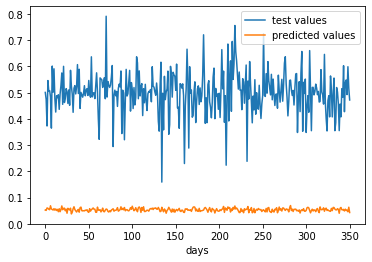

In [35]:
plt.figure().set_size_inches(16,12)
main_df.plot(label='test values',y='test values',x='days')
main_df['predicted values'].plot(label='predicted values')

plt.legend()

In [36]:
# # Revert prediction back to actual scale
# def unnormalize(price):
#     '''Revert values to their unnormalized amounts'''
#     price = price*(max_price-min_price)+min_price
#     return(price)

In [37]:
# def unnormalize(price):
# #     '''Revert values to their unnormalized amounts'''
#      preds = scaler.inverse_transform(predictions)[:, [0]].flatten()
#      return(preds.tolist())

In [38]:
# # Store back-scaled predictions
# unnorm_predictions = []
# for pred in predictions:
#     unnorm_predictions.append(unnormalize(pred))

# # Store back-scaled actuals
# unnorm_y_test = []
# for y in y_test:
#     unnorm_y_test.append(unnormalize(y))

In [39]:
# unnorm_predictions

In [40]:
#unnorm_y_test

In [41]:
#Calculate the median absolute error for the predictions
#mae(unnorm_y_test, unnorm_predictions)

In [42]:
#pd.Series(unnorm_y_test).describe()

In [43]:
# def news_to_int(news):
#     '''Convert your created news into integers'''
#     ints = []
#     for word in news.split():
#         if word in vocab_to_int:
#             ints.append(vocab_to_int[word])
#         else:
#             ints.append(vocab_to_int['<UNK>'])
#     return ints

In [44]:
# def padding_news(news):
#     '''Adjusts the length of your created news to fit the model's input values.'''
#     padded_news = news
#     if len(padded_news) < max_daily_length:
#         for i in range(max_daily_length-len(padded_news)):
#             padded_news.append(vocab_to_int["<PAD>"])
#     elif len(padded_news) > max_daily_length:
#         padded_news = padded_news[:max_daily_length]
#     return padded_news

In [45]:
# Default news that you can use

# create_news =  "Woman says note from Chinese 'prisoner' was hidden in new purse. \
#                21,000 AT&T workers poised for Monday strike \
#                housands march against Trump climate policies in D.C., across USA \
#                Kentucky judge won't hear gay adoptions because it's not in the child's \"best interest\" \
#                Multiple victims shot in UTC area apartment complex \
#                Drones Lead Police to Illegal Dumping in Riverside County | NBC Southern California \
#                An 86-year-old Californian woman has died trying to fight a man who was allegedly sexually assaulting her 61-year-old friend. \
#                Fyre Festival Named in $5Million+ Lawsuit after Stranding Festival-Goers on Island with Little Food, No Security. \
#                The \"Greatest Show on Earth\" folds its tent for good \
#                U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
#                Woman offers undercover officer sex for $25 and some Chicken McNuggets \
#                Ohio bridge refuses to fall down after three implosion attempts \
#                Jersey Shore MIT grad dies in prank falling from library dome \
#                New York graffiti artists claim McDonald's stole work for latest burger campaign \
#                SpaceX to launch secretive satellite for U.S. intelligence agency \
#                Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
#                Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
#                Baker Police officer arrested for allegedly covering up details in shots fired investigation \
#                Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
#                Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
#                South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
#                The Latest: Deal reached on funding government through Sept. \
#                Russia flaunts Arctic expansion with new military bases"

# clean_news = clean_text(create_news)

# int_news = news_to_int(clean_news)

# pad_news = padding_news(int_news)

# pad_news = np.array(pad_news).reshape((1,-1))

# pred = model.predict([pad_news])

# price_change = unnormalize(pred)

# print("The Dow should open: {} from the previous open.".format(np.round(price_change[0][0],2)))